In [1]:
import numpy as np
import matplotlib.pyplot as plt
import huffman as hf
import pickle
import admm_fq_prires as adfp
import utils

In [2]:
rng = np.random.default_rng()

In [3]:
nr_samples = 100000
mean = 0
var = 0.01
decimals = 10
training_data = rng.normal(mean, np.sqrt(var), (nr_samples,)).round(decimals)
training_data = np.concatenate([training_data, np.zeros((int(nr_samples / 15),))])

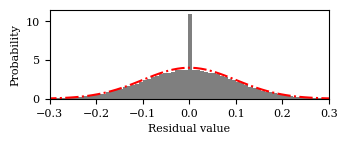

In [4]:
textwidth = 245
linewidth = 1.2
plt.rcParams.update(
    {
        "font.family": "serif",  # use serif/main font for text elements
        "text.usetex": False,  # don't use inline math for ticks (not on docker image)
        "pgf.rcfonts": False,  # don't setup fonts from rc parameters
        "font.size": 8,
    }
)
fig, ax = plt.subplots(figsize=utils.set_size(textwidth, 1.0, (1, 1), 0.4))
ax.hist(training_data, 100, align="mid", color="k", alpha=0.5, density=True)
x = np.linspace(-0.5, 0.5, 100)
y = 1 / (np.sqrt(2 * np.pi * var)) * np.exp(-1 / 2 * x**2 / var)
ax.plot(x, y, "r-.")
ax.set_xlim(-0.3, 0.3)
# ax.grid()
ax.set_xlabel("Residual value")
ax.set_ylabel("Probability")
plt.tight_layout(pad=0.5)
plt.show()
utils.savefig(fig, "dist-example", "pdf")

In [48]:
nr_samples = 1000000
mean = 0
var = 1
decimals = 10
training_data = rng.normal(mean, np.sqrt(var), (nr_samples,))
# training_data = np.concatenate([training_data, np.zeros((int(nr_samples / 15),))])

hist_range = [-4, 4]
nr_bins = 301
step = (hist_range[1] - hist_range[0]) / nr_bins
bins = np.arange(hist_range[0], hist_range[1] + step, step)
centers = ((bins[1:] + bins[:-1]) / 2).round(12)
resample_hist_range = [-4, 4]
resample_nr_bins = 19
resample_step = (resample_hist_range[1] - resample_hist_range[0]) / resample_nr_bins
resample_bins = np.arange(
    resample_hist_range[0], resample_hist_range[1] + resample_step, resample_step
)
resample_centers = ((resample_bins[1:] + resample_bins[:-1]) / 2).round(10)

In [83]:
resample_training_data = np.array([])
for i, cent in enumerate(resample_centers):
    pp = training_data[np.isclose(training_data, cent, atol=step / 2)]
    resample_training_data = np.concatenate(
        [resample_training_data, np.ones(pp.shape) * i]
    )

resample_training_data = resample_training_data.astype(int)

In [85]:
resample_bins_ = resample_bins
resample_bins_[0] = -np.inf
resample_bins_[-1] = np.inf
resample_training_data = np.searchsorted(resample_bins_, training_data, side="left")-1

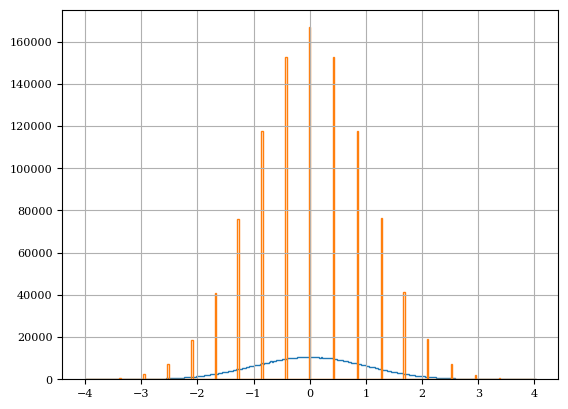

In [86]:
counts, bins = np.histogram(training_data, bins)
plt.stairs(counts, bins)
counts, bins = np.histogram(resample_centers[resample_training_data], bins)
plt.stairs(counts, bins)
plt.grid()
plt.show()

In [64]:
data = list(resample_training_data)
encoded, tree = hf.huffman_encode(data)
table = hf.huffman_table(tree)

# Pretty print the Huffman table
print(f"Symbol Code\n------ ----")
for i, (k, v) in enumerate(
    sorted(hf.huffman_table(tree).items(), key=lambda x: len(x[1]))
):
    # if i > 10:
    #     break
    print(f"{k:<6} {v}")

# Print the bit pattern of the encoded data
# print("".join(hf._bits_from_bytes(encoded)))

# Encode then decode
decoded = hf.huffman_decode(encoded, tree)
numbers_decoded = list(decoded)

# print(numbers - numbers_decoded)
print("Error:", np.linalg.norm(resample_training_data - numbers_decoded))

# print(numbers - numbers_decoded)
print(
    "Error:",
    np.linalg.norm(
        resample_centers[resample_training_data] - resample_centers[numbers_decoded]
    ),
)

Symbol Code
------ ----
9      00
7      010
11     011
10     101
8      110
6      1001
12     1110
5      11110
13     11111
15     100000
4      100010
14     100011
3      1000011
2      10000100
16     100001011
17     1000010100
1      10000101011
0      100001010101
256    1000010101000
18     1000010101001
Error: 0.0
Error: 0.0


In [72]:
np.any(resample_training_data==18)

True

In [73]:
data = np.array([18] * 10)
encoded = hf._encode(data, table)
print("".join(hf._bits_from_bytes(encoded)))

encoded = hf._encode(data, table)
decoded = hf.huffman_decode(encoded, tree)
numbers_decoded = list(decoded)

resample_centers[numbers_decoded]
# numbers_decoded

# print(numbers - numbers_decoded)
# print("Error:", np.linalg.norm(training_data - numbers_decoded))

100001010100110000101010011000010101001100001010100110000101010011000010101001100001010100110000101010011000010101001100001010100110000101010000


array([3.78947368, 3.78947368, 3.78947368, 3.78947368, 3.78947368,
       3.78947368, 3.78947368, 3.78947368, 3.78947368, 3.78947368])

In [81]:
L = 4
vec = rng.normal(size=(L,1))+1J*rng.normal(size=(L,1))
vec = vec*1

x = np.concatenate([vec.real, vec.imag]).squeeze()
# print(x)
inds = np.searchsorted(resample_bins_, x, side="left")-1
# print(inds)
encoded = hf._encode(list(inds), table)
decoded = hf.huffman_decode(encoded, tree)
numbers_decoded = list(decoded)

nn = resample_centers[numbers_decoded]
pp = nn[:L]+1J*nn[L:]

# print(pp.reshape(L,1))
print(vec-pp.reshape(L,1))



[[-0.17186779-0.08277068j]
 [ 0.08015548-0.0381717j ]
 [-0.1127016 -0.02880509j]
 [ 0.03514484+0.11328842j]]


In [ ]:
def encode(vec):
    x = np.concatenate([vec.real, vec.imag]).squeeze()
    # print(x)
    inds = np.searchsorted(resample_bins_, x, side="left")-1
    # print(inds)
    encoded = hf._encode(list(inds), table)
    return encoded

In [ ]:
def decode(encoded):
    decoded = hf.huffman_decode(encoded, tree)
    numbers_decoded = list(decoded)
    nn = resample_centers[numbers_decoded]
    pp = nn[:L]+1J*nn[L:]
    return pp.reshape(L,1)

In [38]:
with open("test.p", "wb") as f:
    pickle.dump(tree, f)

In [39]:
with open("test.p", "rb") as f:
    l_tree = pickle.load(f)

encoded, tree = hf.huffman_encode(data)
hf._bits_from_bytes(encoded)
decoded = hf.huffman_decode(encoded, l_tree)
numbers_decoded = np.frombuffer(decoded)

# print(numbers - numbers_decoded)
print("Error:", np.linalg.norm(training_data - numbers_decoded))

Error: 0.0
